In [62]:
%config InlineBackend.figure_formats = ['svg']

In [102]:
from time import time

import numpy as np
import rustworkx as rx

import matplotlib.pyplot as plt

from qiskit import transpile
from qiskit.circuit import Parameter

from qiskit.quantum_info import Statevector
from qiskit.opflow import VectorStateFn

from qiskit.circuit.library import EfficientSU2
from qiskit.primitives import Estimator
from qiskit.algorithms import NumPyEigensolver as ClassicalEigensolver
from qiskit.algorithms.optimizers import SLSQP, COBYLA, L_BFGS_B, ADAM, GradientDescent, NFT

from qiskit_nature.problems.second_quantization.lattice import Lattice
from qiskit_nature.mappers.second_quantization import LogarithmicMapper

from heisenberg_model import HeisenbergModel

In [64]:
from qiskit.algorithms import MinimumEigensolver, VQEResult

class VQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        def objective(x):
            job = self._estimator.run([self._circuit], [operators], [x])
            estimator_result = job.result()
            value = estimator_result.values[0]
            if self._callback is not None:
                self._callback(value)
            return value
            
        x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        
        res = self._optimizer.minimize(objective, x0=x0)
        

        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

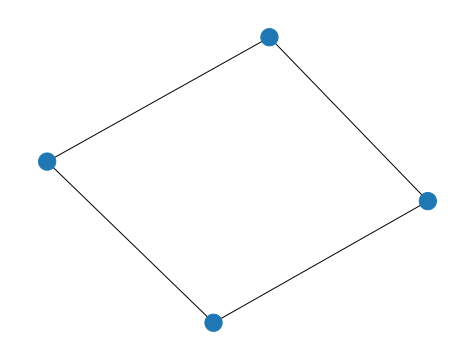

In [65]:
num_sites = 4
t = 1.0

graph = rx.PyGraph(multigraph=False)
graph.add_nodes_from(range(num_sites))
edge_list = [
    (0, 1, t),
    (1, 2, t),
    (2, 3, t),
    (3, 0, t),
    # (3, 4, t),
    # (4, 5, t),
    # (5, 0, t),
]

graph.add_edges_from(edge_list)
line_unit_cell = Lattice(graph)

line_unit_cell.draw()
plt.show()

In [66]:
heisenberg_model = HeisenbergModel.uniform_parameters(
    lattice=line_unit_cell,
    uniform_interaction=1.0,
    uniform_onsite_potential=0.0,
)

logarithmic_mapper = LogarithmicMapper()
hamiltonian = 4 * logarithmic_mapper.map(heisenberg_model.second_q_ops().simplify())
hamiltonian

PauliSumOp(SparsePauliOp(['ZZII', 'IZZI', 'ZIIZ', 'IIZZ', 'YYII', 'IYYI', 'YIIY', 'IIYY', 'XXII', 'IXXI', 'XIIX', 'IIXX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j]), coeff=1)

In [144]:
def bmatrix(a):
    """Returns a LaTeX bmatrix

    :a: numpy array
    :returns: LaTeX bmatrix as a string
    """
    if len(a.shape) > 2:
        raise ValueError('bmatrix can at most display two dimensions')
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{bmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv +=  [r'\end{bmatrix}']
    return '\n'.join(rv)

In [145]:
print(bmatrix(hamiltonian.eval().primitive.data.astype(int)))

\begin{bmatrix}
  4 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 2 & 0 & 0 & 0 & 0 & 0 & 2 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
  0 & 2 & 0 & 0 & 2 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 2 & 0 & 0 & 0 & 0 & 2 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 2 & 0 & 0 & 0 & 0 & 0 & 2 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 0 & 2 & 0 & -4 & 2 & 0 & 0 & 2 & 0 & 0 & 2 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 2 & 0 & 0 & 0 & 0 & 2 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 2 & 0 & 0 & 2 & 0\\
  0 & 2 & 0 & 0 & 2 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 2 & 0 & 0 & 0 & 0 & 2 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 0 & 2 & 0 & 0 & 2 & 0 & 0 & 2 & -4 & 0 & 2 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0 & 2 & 0 & 0 & 0 & 0 & 0 & 2 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 2 & 0 & 0 & 0 & 0 & 2 & 0 & 0 & 0 & 0 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 2 & 0 & 0 & 2 & 0\\
  0 & 0 & 0 & 0 & 0 & 0 & 0 & 2 & 0 & 0 & 0 & 0 & 0 & 2 & 

/var/folders/r1/027lgns16j553ds7rms76qf80000gn/T/ipykernel_17176/2407667632.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  print(bmatrix(hamiltonian.eval().primitive.data.astype(int)))


In [143]:
for jawn in hamiltonian.eval().primitive.data.astype(int):
    print("{", ",".join(map(str, jawn)), "},")

{ 4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0 },
{ 0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0 },
{ 0,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0 },
{ 0,0,0,0,0,2,0,0,0,0,2,0,0,0,0,0 },
{ 0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0 },
{ 0,0,0,2,0,-4,2,0,0,2,0,0,2,0,0,0 },
{ 0,0,0,0,0,2,0,0,0,0,2,0,0,0,0,0 },
{ 0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0 },
{ 0,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0 },
{ 0,0,0,0,0,2,0,0,0,0,2,0,0,0,0,0 },
{ 0,0,0,2,0,0,2,0,0,2,-4,0,2,0,0,0 },
{ 0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0 },
{ 0,0,0,0,0,2,0,0,0,0,2,0,0,0,0,0 },
{ 0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0 },
{ 0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0 },
{ 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4 },


/var/folders/r1/027lgns16j553ds7rms76qf80000gn/T/ipykernel_17176/4023989667.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  for jawn in hamiltonian.eval().primitive.data.astype(int):


In [67]:
exact_solver = ClassicalEigensolver(k=3)
exact_result = exact_solver.compute_eigenvalues(hamiltonian)
print(exact_result.eigenvalues)

gs_energy = np.round(exact_result.eigenvalues[0], 4)

[-8. -4. -4.]


In [142]:
gs_sv = exact_result.eigenstates[0].primitive.data * np.exp(1j * -np.angle(exact_result.eigenstates[0].primitive.data[5])) # 3, 5, 6, 9, 10, 12

ansatz_sv = np.zeros(2**4)
for i in [3, 5, 6, 9, 10, 12]:
    ansatz_sv[i] = gs_sv[i]

ansatz_sv

/var/folders/r1/027lgns16j553ds7rms76qf80000gn/T/ipykernel_17176/2366917636.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  ansatz_sv[i] = gs_sv[i]


array([ 0.        ,  0.        ,  0.        , -0.28867513,  0.        ,
        0.57735027, -0.28867513,  0.        ,  0.        , -0.28867513,
        0.57735027,  0.        , -0.28867513,  0.        ,  0.        ,
        0.        ])

In [139]:
print(exact_result.eigenstates[0].primitive.data[5] * np.exp(1j * -np.angle(exact_result.eigenstates[0].primitive.data[5])))
print(exact_result.eigenstates[0].primitive.data[10] * np.exp(1j * -np.angle(exact_result.eigenstates[0].primitive.data[10])))

(0.5773502691896258+1.3877787807814457e-17j)
(0.5773502691896257-4.163336342344337e-17j)


(0.10054694324698528+0.9949323153881813j)

In [97]:
exact_eigenstate_circuit = exact_result.eigenstates[0].to_circuit_op().to_circuit()

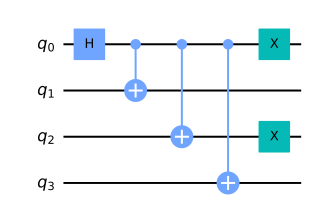

<IPython.core.display.Latex object>

In [116]:
ansatz = QuantumCircuit(4)

ansatz.h(0)
ansatz.cx(0, 1)
ansatz.cx(0, 2)
ansatz.cx(0, 3)

ansatz.x(0)
ansatz.x(2)

ansatz_sv = Statevector(ansatz)

display(ansatz.draw("mpl"))
ansatz_sv.draw("latex")

In [125]:
np.abs(ansatz_sv.inner(exact_result.eigenstates[0].primitive) )**2

0.6666666666666669

In [127]:
(2/3) * -8

-5.333333333333333

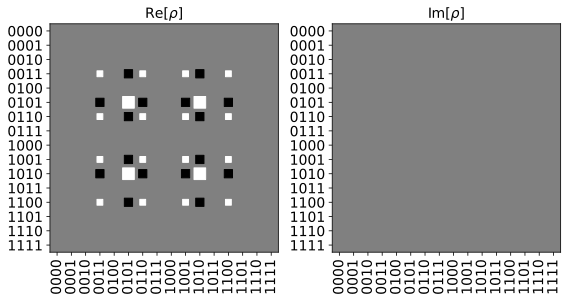

In [114]:
exact_result.eigenstates[0].primitive.draw("hinton")

In [98]:
estimator = Estimator([exact_eigenstate_circuit], [hamiltonian])
estimator.run([exact_eigenstate_circuit], [hamiltonian]).result()

EstimatorResult(values=array([-8.]), metadata=[{}])

Ground State #0


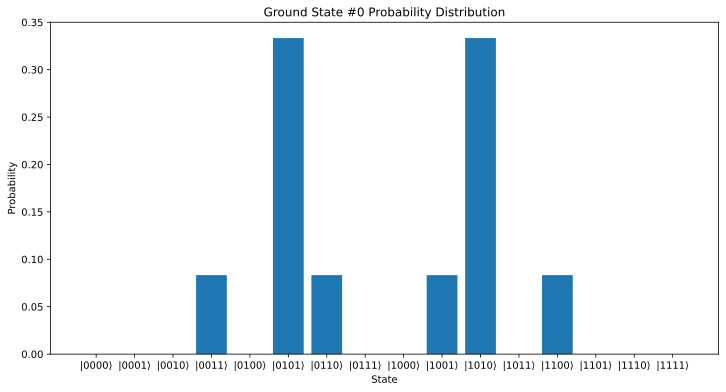

Probabilities
	|0000> ==> 0.00
	|0001> ==> 0.00
	|0010> ==> 0.00
	|0011> ==> 0.08
	|0100> ==> 0.00
	|0101> ==> 0.33
	|0110> ==> 0.08
	|0111> ==> 0.00
	|1000> ==> 0.00
	|1001> ==> 0.08
	|1010> ==> 0.33
	|1011> ==> 0.00
	|1100> ==> 0.08
	|1101> ==> 0.00
	|1110> ==> 0.00
	|1111> ==> 0.00



In [75]:
for index, statevector in enumerate(exact_result.eigenstates[0:1]):
    print(f"Ground State #{index}")

    states = [f"{state:0{num_sites}b}" for state in range(2**num_sites)]
    probabilities = [ np.abs(statevector.primitive.data[state]) ** 2 for state in range(2**num_sites) ]

    plt.figure(figsize=(12,6))
    plt.bar([f"$|{state}\\rangle$" for state in states], probabilities)
    plt.xlabel("State")
    plt.ylabel("Probability")
    plt.title(f"Ground State #{index} Probability Distribution")
    plt.show()

    print("Probabilities")
    for state, probability in zip(states, probabilities):
        print(f"\t|{state}> ==> {probability:.2f}")

    print()

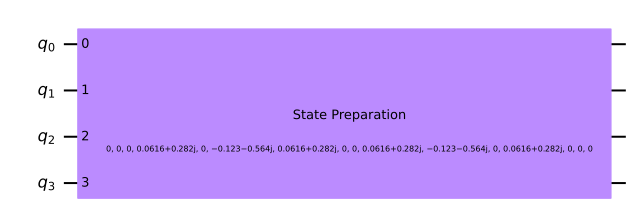

In [8]:
from qiskit import QuantumCircuit

gs_circuit = exact_result.eigenstates[0].to_circuit_op().to_circuit()
gs_circuit.draw("mpl")

45


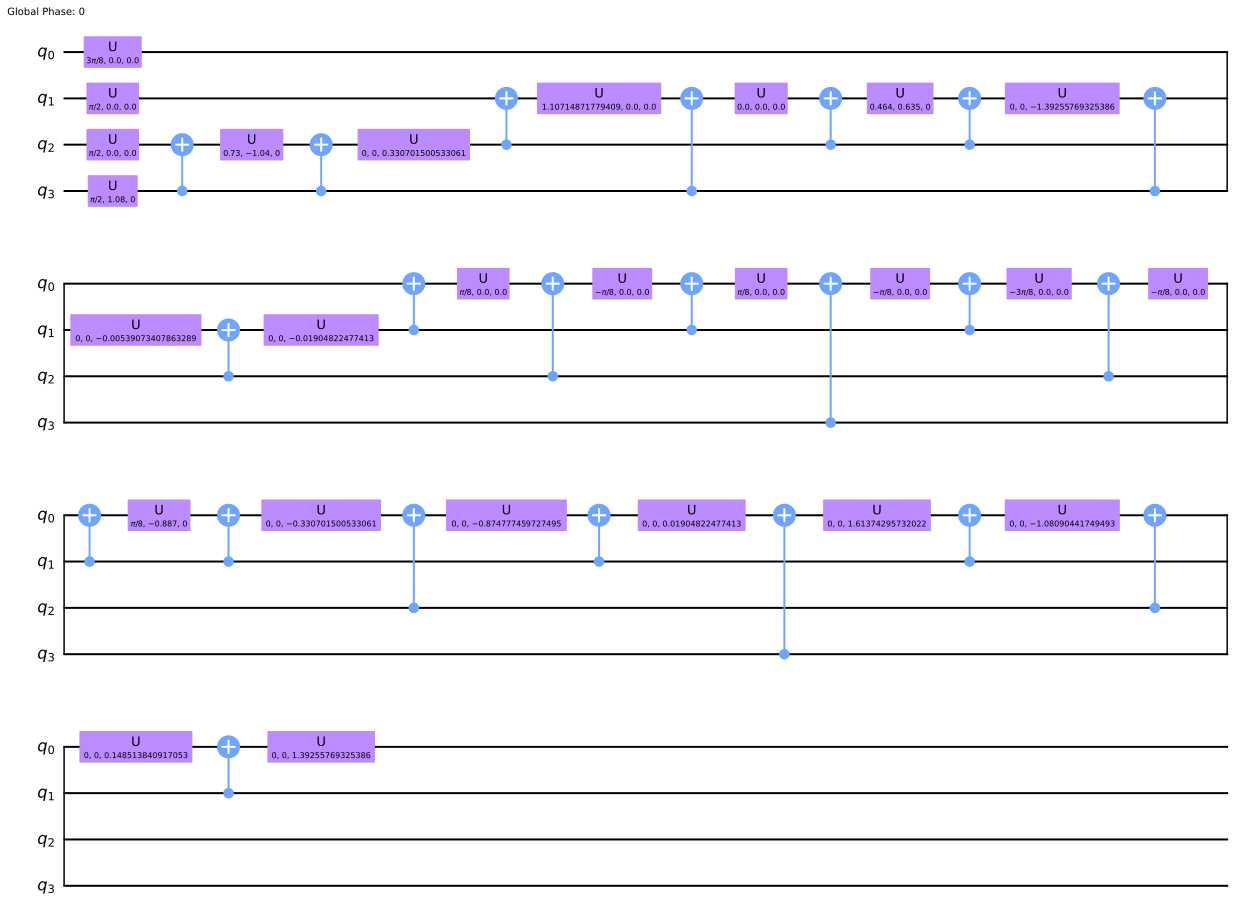

In [11]:
from qiskit import transpile

transpiled_gs_circuit = transpile(gs_circuit, basis_gates=['cx', 'u'], optimization_level=3)
print(transpiled_gs_circuit.depth())
transpiled_gs_circuit.draw("mpl")

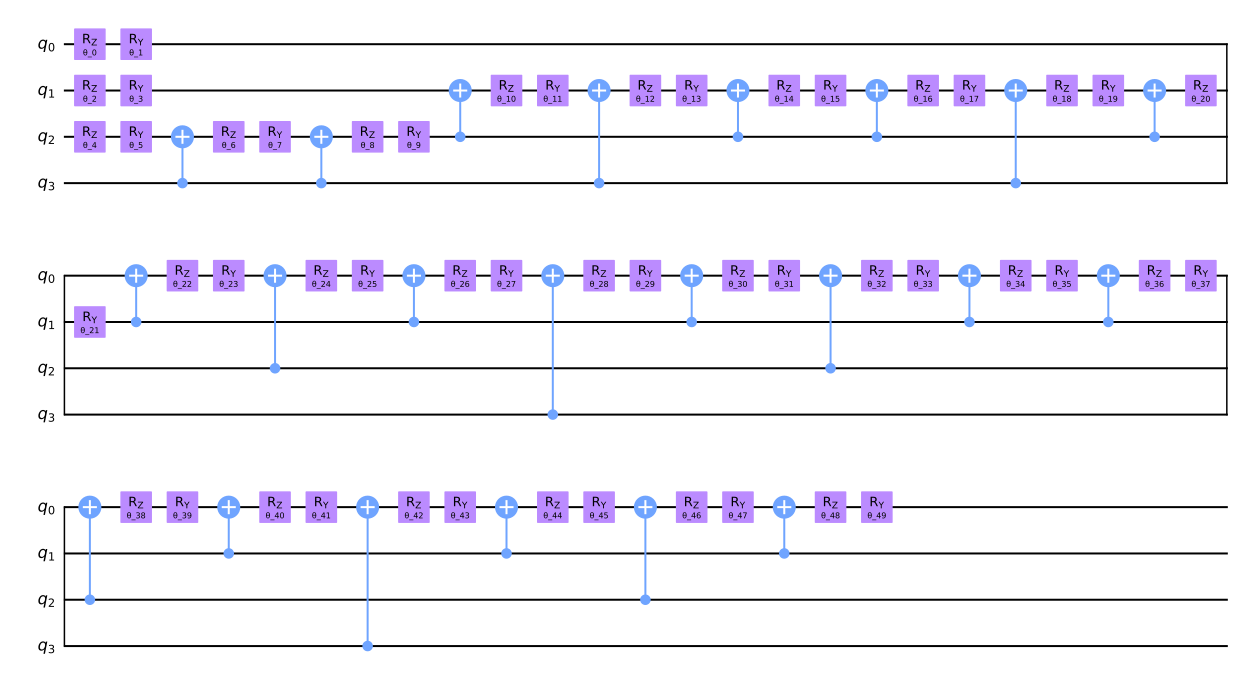

In [16]:
from qiskit.circuit import Parameter

ansatz = QuantumCircuit(4)

j = 0

for i in range(3):
    ansatz.rz(Parameter('θ_' + str(j)), i)
    j += 1
    ansatz.ry(Parameter('θ_' + str(j)), i)
    j += 1

ansatz.cx(3, 2)
ansatz.rz(Parameter('θ_' + str(j)), 2)
j += 1
ansatz.ry(Parameter('θ_' + str(j)), 2)
j += 1

ansatz.cx(3, 2)
ansatz.rz(Parameter('θ_' + str(j)), 2)
j += 1
ansatz.ry(Parameter('θ_' + str(j)), 2)
j += 1

ansatz.cx(2, 1)
ansatz.rz(Parameter('θ_' + str(j)), 1)
j += 1
ansatz.ry(Parameter('θ_' + str(j)), 1)
j += 1

ansatz.cx(3, 1)
ansatz.rz(Parameter('θ_' + str(j)), 1)
j += 1
ansatz.ry(Parameter('θ_' + str(j)), 1)
j += 1

ansatz.cx(2, 1)
ansatz.rz(Parameter('θ_' + str(j)), 1)
j += 1
ansatz.ry(Parameter('θ_' + str(j)), 1)
j += 1

ansatz.cx(2, 1)
ansatz.rz(Parameter('θ_' + str(j)), 1)
j += 1
ansatz.ry(Parameter('θ_' + str(j)), 1)
j += 1

ansatz.cx(3, 1)

ansatz.rz(Parameter('θ_' + str(j)), 1)
j += 1
ansatz.ry(Parameter('θ_' + str(j)), 1)
j += 1
ansatz.cx(2, 1)
ansatz.rz(Parameter('θ_' + str(j)), 1)
j += 1
ansatz.ry(Parameter('θ_' + str(j)), 1)
j += 1

ansatz.cx(1, 0)
ansatz.rz(Parameter('θ_' + str(j)), 0)
j += 1
ansatz.ry(Parameter('θ_' + str(j)), 0)
j += 1

ansatz.cx(2, 0)
ansatz.rz(Parameter('θ_' + str(j)), 0)
j += 1
ansatz.ry(Parameter('θ_' + str(j)), 0)
j += 1

ansatz.cx(1, 0)
ansatz.rz(Parameter('θ_' + str(j)), 0)
j += 1
ansatz.ry(Parameter('θ_' + str(j)), 0)
j += 1

ansatz.cx(3, 0)
ansatz.rz(Parameter('θ_' + str(j)), 0)
j += 1
ansatz.ry(Parameter('θ_' + str(j)), 0)
j += 1

ansatz.cx(1, 0)
ansatz.rz(Parameter('θ_' + str(j)), 0)
j += 1
ansatz.ry(Parameter('θ_' + str(j)), 0)
j += 1

ansatz.cx(2, 0)
ansatz.rz(Parameter('θ_' + str(j)), 0)
j += 1
ansatz.ry(Parameter('θ_' + str(j)), 0)
j += 1

ansatz.cx(1, 0)
ansatz.rz(Parameter('θ_' + str(j)), 0)
j += 1
ansatz.ry(Parameter('θ_' + str(j)), 0)
j += 1

ansatz.cx(1, 0)
ansatz.rz(Parameter('θ_' + str(j)), 0)
j += 1
ansatz.ry(Parameter('θ_' + str(j)), 0)
j += 1

ansatz.cx(2, 0)
ansatz.rz(Parameter('θ_' + str(j)), 0)
j += 1
ansatz.ry(Parameter('θ_' + str(j)), 0)
j += 1

ansatz.cx(1, 0)
ansatz.rz(Parameter('θ_' + str(j)), 0)
j += 1
ansatz.ry(Parameter('θ_' + str(j)), 0)
j += 1

ansatz.cx(3, 0)
ansatz.rz(Parameter('θ_' + str(j)), 0)
j += 1
ansatz.ry(Parameter('θ_' + str(j)), 0)
j += 1

ansatz.cx(1, 0)
ansatz.rz(Parameter('θ_' + str(j)), 0)
j += 1
ansatz.ry(Parameter('θ_' + str(j)), 0)
j += 1

ansatz.cx(2, 0)
ansatz.rz(Parameter('θ_' + str(j)), 0)
j += 1
ansatz.ry(Parameter('θ_' + str(j)), 0)
j += 1

ansatz.cx(1, 0)
ansatz.rz(Parameter('θ_' + str(j)), 0)
j += 1
ansatz.ry(Parameter('θ_' + str(j)), 0)
j += 1

ansatz.draw("mpl")

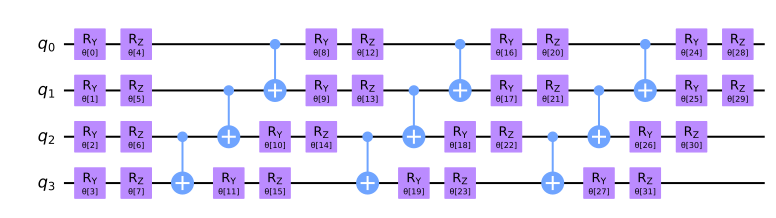

In [45]:
ansatz = EfficientSU2(4).decompose()
ansatz.draw("mpl", fold=300)

In [60]:
optimizer = ADAM(maxiter=100)
# optimizer = NFT(maxiter=300)

In [61]:
display(ansatz.draw("mpl"))

intermediate_info = []
def callback(value):
        intermediate_info.append(value)

estimator = Estimator([ansatz], [hamiltonian])

vqe = VQE(estimator, ansatz, optimizer, callback=callback)

start = time()
result = vqe.compute_minimum_eigenvalue(hamiltonian)
end = time()

print(result)
print(f'Execution Time (s): {end - start:.2f}')

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 2000,
    'eigenstate': None,
    'eigenvalue': -7.999530206065654,
    'optimal_circuit': None,
    'optimal_parameters': array([ 6.69609465e-01,  3.18967530e-02,  1.38059936e+00, -4.03805482e-01,
        1.22639297e+00,  1.39779987e+00,  5.88100117e-02,  2.22256533e-01,
       -5.53870618e-01,  5.57764360e-01, -4.60226505e-01,  6.88546907e-01,
        8.14230426e-01, -7.28776175e-01,  1.24147932e+00,  1.25473632e-01,
        1.56610687e+00, -2.21860347e-02,  8.59051879e-04,  4.36501755e-01,
       -3.66957894e-02,  4.37613411e-01, -1.88440228e-02,  4.38217166e-02,
       -1.10500298e+00,  2.03367100e+00,  2.46733032e-02,  2.03771998e+00,
        7.15694226e-01,  6.97890952e-01, -8.68025472e-01,  4.93028285e-01]),
    'optimal_point': None,
    'optimal_value': None,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': None}
Execution Time (s): 4572.12


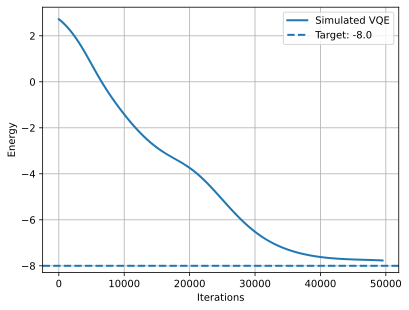

In [59]:
plt.plot(intermediate_info, lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')

plt.axhline(y=gs_energy, ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
# plt.show()

plt.savefig('optimization.svg', format="svg")

In [ ]:
def relative_error(target, measured):
    return abs((target - measured) / target)

error = relative_error(gs_energy, result.eigenvalue)

print(f'Expected ground state energy: {gs_energy:.10f}.')
print(f'Computed ground state energy: {result.eigenvalue:.10f}.')
print(f'Relative error: {error:.8f}.')